In [1]:
import torch
from GeospatialFM.models.low_rank_attention import LowRankBlock, get_perception_field_mask
import matplotlib.pyplot as plt
import math
from GeospatialFM.models.pos_embed import PositionalChannelEmbedding
from GeospatialFM.models.multi_modal_low_rank_vit import MultiModalLowRankViTConfig 
import numpy as np
from GeospatialFM.models.mae import MultiModalMAEViT 
import os
import glob
import json
import rasterio
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
from torchvision.transforms import functional as TF
from functools import partial
from torch.utils.data import DataLoader
from GeospatialFM.datasets.utils import get_ssl4eo_metadata
from GeospatialFM.data import apply_transforms, pretrain_transform, multimodal_collate_fn

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [118]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define configuration
config = MultiModalLowRankViTConfig(
    patch_size=16,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    use_perception_field_mask=True,
    attention_radius=640,
)

# Initialize model
model = MultiModalMAEViT(config)
model.to('cuda:2', dtype=torch.bfloat16)

# Create the dataset


# Define wavelengths
optical_channel_wv = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4]
radar_channel_wv = [1575.4, 1660.0]

# convert to 2D tensor
optical_channel_wv = torch.tensor(optical_channel_wv).unsqueeze(0)
radar_channel_wv = torch.tensor(radar_channel_wv).unsqueeze(0)

# Set model to evaluation mode
model.train()

# Run forward pass
output = model(
    optical=optical,
    radar=radar,
    optical_channel_wv=optical_channel_wv,
    radar_channel_wv=radar_channel_wv,
    mask_ratio=0.75,
    channel_mask_ratio=0.5,
    spatial_resolution=10,
    modal=None
)

# Check output
expected_keys = [
    'target',
    'optical_channel_mask', 'optical_recon', 'optical_pos_mask',
    'radar_channel_mask', 'radar_recon', 'radar_pos_mask',
    'multi_channel_mask', 'multi_recon', 'multi_pos_mask'
]

for key in expected_keys:
    assert key in output, f"Missing key in output: {key}"
    assert isinstance(output[key], torch.Tensor), f"Output {key} is not a tensor"

In [119]:
# print the shape of the masks
print(output['optical_channel_mask'].shape, output['radar_channel_mask'].shape, output['multi_channel_mask'].shape)
print(output['optical_pos_mask'].shape, output['radar_pos_mask'].shape, output['multi_pos_mask'].shape)


torch.Size([2, 15]) torch.Size([2, 15]) torch.Size([2, 15])
torch.Size([2, 196]) torch.Size([2, 196]) torch.Size([2, 196])


In [124]:
loss = {}
target = output['target']
for modal in ['optical', 'radar', 'multi']:
    if f'{modal}_recon' in output:
        recon = output[f'{modal}_recon']
        channel_mask = output[f'{modal}_channel_mask']
        pos_mask = output[f'{modal}_pos_mask']
        # positional MSE
        pos_loss = torch.mean((recon - target) ** 2 * pos_mask.unsqueeze(1).unsqueeze(-1).expand_as(recon)) / (pos_mask.sum() + 1e-5)
        # channel MSE
        channel_loss = torch.mean((recon - target) ** 2 * channel_mask.unsqueeze(-1).unsqueeze(-2).expand_as(recon)) / (channel_mask.sum() + 1e-5)

In [121]:
output['optical_channel_mask'], output['radar_channel_mask'], output['multi_channel_mask']

(tensor([[1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.]],
        device='cuda:2'),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]],
        device='cuda:2'),
 tensor([[0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.],
         [0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.]],
        device='cuda:2'))

In [4]:
x = torch.randn(1, 13, 196, 768)

In [5]:
pos_chan = pos_chan_embed(x, 10, np.arange(13))

In [6]:
pos_chan.shape

torch.Size([1, 14, 197, 768])

In [7]:
pos_chan_1 = pos_chan_embed(x, 10, np.arange(13))

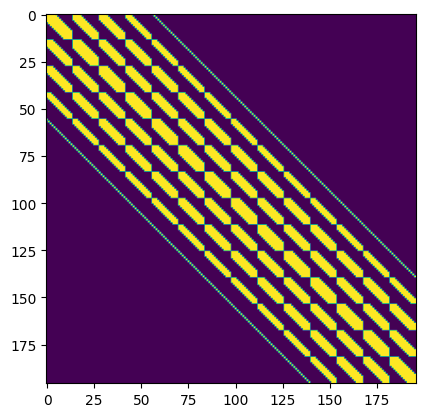

In [97]:
patch_size = 16
num_patches = 196
perception_field_mask = get_perception_field_mask(num_patches, patch_size, 10, attention_radius=640, cls_token=False)
perception_field_mask.shape
plt.imshow(perception_field_mask.numpy())

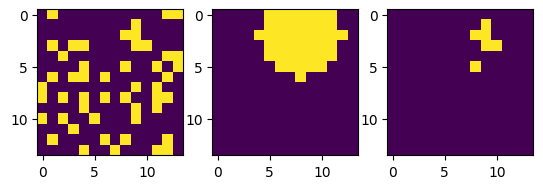

17


In [98]:
one_perception = perception_field_mask[36].reshape(int(math.sqrt(perception_field_mask.shape[1])), int(math.sqrt(perception_field_mask.shape[1]))).numpy()
idx = torch.rand(num_patches)
keep_idx = torch.argsort(idx)[:int(num_patches*0.25)]
random_mask = torch.zeros(num_patches)
random_mask[keep_idx] = 1
random_mask = random_mask.reshape(int(math.sqrt(num_patches)), int(math.sqrt(num_patches)))
# plt.imshow(random_mask.numpy() * one_perception)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(random_mask.numpy())
ax[1].imshow(one_perception)
ax[2].imshow(random_mask.numpy() * one_perception)
plt.show()
print(perception_field_mask[0].reshape(int(math.sqrt(perception_field_mask.shape[1])), int(math.sqrt(perception_field_mask.shape[1]))).numpy().sum())

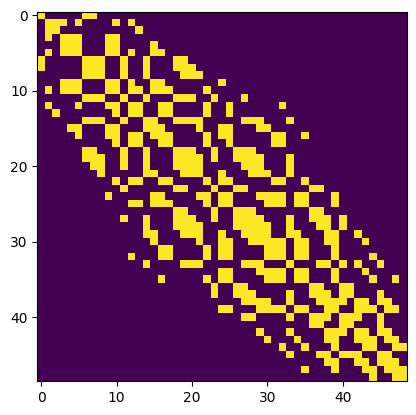

In [99]:
# apply random mask to perception field mask
random_mask_idx = random_mask.reshape(-1).nonzero().squeeze()
perception_field_mask_masked = perception_field_mask[random_mask_idx][:, random_mask_idx]
plt.imshow(perception_field_mask_masked.numpy())

In [2]:
metadata = get_ssl4eo_metadata()
optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]


In [3]:
dataset = load_dataset("GeospatialFM/datasets/ssl4eo", data_dir="/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO")

apply_transform = partial(apply_transforms, optical_mean=optical_mean, optical_std=optical_std, radar_mean=radar_mean, radar_std=radar_std)
collate_fn = partial(multimodal_collate_fn, transform=pretrain_transform)

dataset = dataset.map(apply_transform)

In [4]:

batch_size = 5
train_loader = DataLoader(
    dataset['train'], 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=collate_fn
)

for batch in train_loader:
    print(batch['optical'].shape)
    print(batch['radar'].shape)
    print(batch['optical_channel_wv'].shape)
    print(batch['radar_channel_wv'].shape)
    print(batch['spatial_resolution'])
    

torch.Size([5, 13, 224, 224])
torch.Size([5, 2, 224, 224])
torch.Size([1, 13])
torch.Size([1, 2])
tensor(10)
torch.Size([5, 13, 224, 224])
torch.Size([5, 2, 224, 224])
torch.Size([1, 13])
torch.Size([1, 2])
tensor(10)


In [37]:
rgb = torch.tensor(dataset['train'][4]['optical'])[[3, 2, 1]].numpy().transpose(1, 2, 0)
rgb = norm_img(rgb)
plt.imshow(rgb)
plt.show()

ValueError: axes don't match array

In [67]:
pos_chan_embed.pos_embed.unsqueeze(1).repeat(1, 14, 1, 1).shape, pos_chan_embed.channel_embed.unsqueeze(2).repeat(1, 1, 197, 1).shape

(torch.Size([1, 14, 197, 768]), torch.Size([1, 14, 197, 768]))

In [30]:
data_path = "/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO"
modal = "s1"
modal_path = os.path.join(data_path, modal)


In [31]:
for img_id in os.listdir(modal_path):
    for date in os.listdir(os.path.join(modal_path, img_id)):
        for file in os.listdir(os.path.join(modal_path, img_id, date)):
            if file.endswith(".json"):
                json_path = os.path.join(modal_path, img_id, date, file)
                with open(json_path, 'r') as f:
                    data = json.load(f)
                print(data)
            else:
                # print the size of the tif image
                tif_path = os.path.join(modal_path, img_id, date, file)
                with rasterio.open(tif_path) as src:
                    print(src.read(1).shape)
        break
    break


{'GRD_Post_Processing_facility_country': 'Germany', 'GRD_Post_Processing_facility_name': 'Copernicus S1 Core Ground Segment - DPA', 'GRD_Post_Processing_facility_org': 'ESA', 'GRD_Post_Processing_facility_site': 'DLR-Oberpfaffenhofen', 'GRD_Post_Processing_software_name': 'Sentinel-1 IPF', 'GRD_Post_Processing_software_version': '003.31', 'GRD_Post_Processing_start': 1600670326272, 'GRD_Post_Processing_stop': 1600670964000, 'S1TBX_Calibration_vers': '7.0.2', 'S1TBX_SAR_Processing_vers': '7.0.2', 'SLC_Processing_facility_country': 'Germany', 'SLC_Processing_facility_name': 'Copernicus S1 Core Ground Segment - DPA', 'SLC_Processing_facility_org': 'ESA', 'SLC_Processing_facility_site': 'DLR-Oberpfaffenhofen', 'SLC_Processing_software_name': 'Sentinel-1 IPF', 'SLC_Processing_software_version': '003.31', 'SLC_Processing_start': 1600670417000, 'SLC_Processing_stop': 1600670725000, 'SNAP_Graph_Processing_Framework_GPF_vers': '7.0.3', 'cycleNumber': 140, 'familyName': 'SENTINEL-1', 'instrument

In [32]:
date

'S1B_IW_GRDH_1SDV_20200921T034625_20200921T034654_023468_02C945_98D9'

In [14]:
def norm_img(img):
    return (img - img.min()) / (img.max() - img.min())

'/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO/s2c/0241734'

In [51]:
# # build metadata for ssl4eo dataset
# data_path = "/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO"
# modals = ["s1", "s2c"]
# indices = sorted(os.listdir(os.path.join(data_path, "s2c")))

# def extract_timestamp(subdir, index):
#     return int(subdir.split("_")[index].split('T')[0])

In [67]:
# metadata = dict(index=[], s1_t0=[], s2c_t0=[], s1_t1=[], s2c_t1=[], s1_t2=[], s2c_t2=[], s1_t3=[], s2c_t3=[])
# for index in tqdm(indices):
#     metadata["index"].append(index)
#     for modal in modals:
#         modal_path = os.path.join(data_path, modal, index)
#         timestamps = os.listdir(modal_path)
#         if modal == "s1":
#             timestamps.sort(key=lambda x: extract_timestamp(x, 4))
#         else:
#             timestamps.sort(key=lambda x: extract_timestamp(x, 0))
#         for t, timestamp in enumerate(timestamps):
#             metadata[f"{modal}_t{t}"].append(os.path.join(modal, index, timestamp))

100%|██████████| 251079/251079 [01:33<00:00, 2697.24it/s]


In [69]:
# # convert metadata to csv
# df = pd.DataFrame(metadata)
# df.to_csv("/home/haozhesi/Dropbox/GeospatialFM/GeospatialFM/datasets/ssl4eo/metadata.csv", index=False)

In [83]:
# import random
# for i in range(10):
#     print(random.randint(0, 3))

1
2
1
2
3
1
1
0
3
0
